# Mission - Classifiez automatiquement des informations

Vous êtes mandaté en tant que Consultant Data Scientist par le département RH de votre client. Il s’agit de l'ESN TechNova Partners, spécialisée dans le conseil en transformation digitale et la vente d’applications en SaaS.
 
Ils font face à un turnover plus élevé que d'habitude et ils souhaitent identifier les causes racines potentielles derrière ces démissions.

### Importation des librairies

In [2]:
# Librairies "classiques"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preprocess et modèles
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, precision_recall_curve, auc, f1_score, balanced_accuracy_score

from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier

# Fonctions python créées
from utils import prepare_xy
from utils import scaler_ou_non
from utils import generate_full_model_evaluation

### On reprend les éléments du notebook de l'étape 1

In [3]:
donnees_modelisation = pd.read_csv("../Data/Processed/Projet_4_etape1_clean.csv")

# Partie 4 - Améliorez l'approche de classification

### Recommandation 1 - Avant toute implémentation en code, mettre sur le papier votre approche de modélisation. C’est-à-dire : avec quelle méthodologie je découpe mon jeu de données en apprentissage et test, de quelles métriques d’évaluation je vais avoir besoin etc.

* L'objectif va être de gérer le déséquilibre de notre jeu de données. Nous devons également mieux le stratifier et déterminer le bon seuil de classification avec une courbe PR. Nous sommes dans une situation de déséquilibre alors la courbe ROC n'est pas adaptée.

* D'après les résultats obtenus par l'étape 3, il semble important de mettre l'accent sur l'amélioration de la métrique Recall qui n'est pas bonne pour chacun des modèles testés.
* D'autant plus dans un sens métier, il est plus judicieux de bien trouver les Faux Négatifs, c'est à dire les salariés qui ont démissionné mais qui sont considérés comme encore dans l'entreprise.
* La métrique Recall / la matrice de confusion / la balanced_accuracy  vont nous permettre de mieux comprendre les résultats.
* La métrique Accuracy n'est pas utilisable pour le moment car le déséquilibre fausse la métrique, elle va trouver facilement le Non qui domine notre jeu de données à hauteur de 84%.

Dans un premier temps nous allons faire une validation croisée pour analyser la moyenne et l'écart-type de nos différents modèles et en sélectionner le plus pertinent.
Dans un deuxième temps nous irons plus loin dans l'analyse du meilleur modèle, nous regarderons sa courbe PR, son histogramme des probabilités et nous déterminerons le seuil optimal pour gérer le déséquilibre.

Réalisation de différents tests sur 2 modèles non linéaires (il est demandé dans l'énoncé d'utiliser un modèle non linéaire):
* Choix du modèle non-linéaire RandomForest
* Choix du modèle non-linéaire CatBoost

## Création d'une fonction pour appliquer nos modèles

### Application des recommandations suivantes :
* Capitaliser sur les fonctions existantes dans sklearn et privilégier leur utilisation (notamment pour la stratification), à moins que votre méthodologie soit très personnalisée.

* Pendant votre validation croisée, stocker les métriques de chaque itération de Fold dans une liste. Il est très utile de calculer une moyenne ainsi qu’un écart-type sur ces listes. Cela vous donnera une bonne indication sur l’existence ou non d’un overfit, ainsi que la capacité d’un modèle à généraliser son apprentissage à de nouvelles données.

* Utiliser la courbe précision rappel pour déterminer le seuil optimal que doit utiliser votre modèle pour classifier vos observations.

* Si vous êtes déjà à l’aise au niveau du code pour utiliser les différents concepts et librairies, vous pouvez vous intéresser aux fonctionnalités pipelines de sklearn pour mieux organiser vos modélisations.

#### Récupération de notre fonction pour la séparation de jeu

* Dans notre fonction sous utils.py nous respectons bien la consigne pour la stratification de notre jeu de données, on utilise StratifiedKFold

In [4]:
# Transformation + séparation X et y dans utils.py
X, y = prepare_xy(donnees_modelisation, target_col="a_quitte_l_entreprise")
features_a_scaler, features_encodees = scaler_ou_non()

target_col = "a_quitte_l_entreprise"

train_data_df = pd.read_csv("../Data/Processed/train_data_df.csv")
test_data_df  = pd.read_csv("../Data/Processed/test_data_df.csv")

X_train = train_data_df.drop(columns=[target_col])
y_train = train_data_df[target_col]
X_test  = test_data_df.drop(columns=[target_col])
y_test  = test_data_df[target_col]

#### Nous commençons par faire tourner notre modèle RandomForest avec des paramètres et celui de CatBoost également afin de les comparer.

##### RandomForest

In [5]:
pipe = generate_full_model_evaluation(
    RandomForestClassifier(random_state=42,
    n_estimators=300, # nombre d’arbres dans la forêt
    max_depth=3, # profondeur maximale de chaque arbre
    min_samples_split=10, # nombre minimum d’échantillons pour diviser un noeud
    class_weight={0: 0.60, 1: 3.12}), # pondération pour équilibrer classes majoritaire/minoritaire
    train_data_df,
    test_data_df)

=== Résultats CV (train vs val) ===
precision         : train 0.546 ± 0.003 vs val 0.444 ± 0.043
recall            : train 0.747 ± 0.010 vs val 0.563 ± 0.073
f1                : train 0.631 ± 0.002 vs val 0.490 ± 0.012
average_precision : train 0.725 ± 0.019 vs val 0.560 ± 0.017
balanced_accuracy : train 0.814 ± 0.004 vs val 0.711 ± 0.018
 Classification Report — TRAIN
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       986
           1       0.48      0.76      0.59       190

    accuracy                           0.83      1176
   macro avg       0.71      0.80      0.74      1176
weighted avg       0.87      0.83      0.84      1176

Classification Report — TEST
              precision    recall  f1-score   support

           0       0.95      0.82      0.88       247
           1       0.45      0.79      0.57        47

    accuracy                           0.81       294
   macro avg       0.70      0.80      0.73       294


##### CatBoost

In [6]:
pipe = generate_full_model_evaluation(CatBoostClassifier(
    iterations=300, #nombre d’arbres boostés
    depth=2, # profondeur des arbres
    learning_rate=0.02, # vitesse d’apprentissage
    class_weights=[1, 5], # pondération des classes
    random_state=42,
    verbose=0),
    train_data_df,
    test_data_df)

=== Résultats CV (train vs val) ===
precision         : train 0.483 ± 0.006 vs val 0.419 ± 0.021
recall            : train 0.803 ± 0.023 vs val 0.663 ± 0.077
f1                : train 0.603 ± 0.011 vs val 0.510 ± 0.012
average_precision : train 0.738 ± 0.011 vs val 0.598 ± 0.015
balanced_accuracy : train 0.819 ± 0.011 vs val 0.742 ± 0.022
 Classification Report — TRAIN
              precision    recall  f1-score   support

           0       0.95      0.83      0.89       986
           1       0.47      0.76      0.58       190

    accuracy                           0.82      1176
   macro avg       0.71      0.80      0.73      1176
weighted avg       0.87      0.82      0.84      1176

Classification Report — TEST
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       247
           1       0.36      0.68      0.47        47

    accuracy                           0.76       294
   macro avg       0.65      0.73      0.66       294


#### Interprétation des résultats :

Nous obtenons des meilleurs résultats pour le modèle de CatBoost sur les catégories qui nous intéresse le plus :
* Meilleur recall sur le test : 0.66 vs 0.56
* Meilleur balanced_accuracy : 0.74 vs 0.71
* Egalement meilleur f1 : 0.51 vs 0.49

On retient donc le modèle de CatBoost pour la suite de la mission.

### Afin de retrouver notre seuil optimal, on utilise le calcul fbeta afin de mettre l'accent sur le recall
* On le calcul sur nos données de train

In [7]:
beta = 2.0  # met plus de poids sur le recall
proba_train = pipe.predict_proba(X_train)[:, 1]

prec_tr, rec_tr, thr_tr = precision_recall_curve(y_train, proba_train)
# Création du seuil fbeta
beta = 2 # afin de mettre des poids supplémentaires sur le recall
f_beta = (1 + beta**2) * (prec_tr * rec_tr) / (beta**2 * prec_tr + rec_tr)
idx = int(np.nanargmax(f_beta))
best_thr = float(thr_tr[idx])
print(f"Notre seuil optimal fbeta est de {best_thr:.3f}")

Notre seuil optimal fbeta est de 0.457


#### Histogramme des probabilités + calcul de proba_test

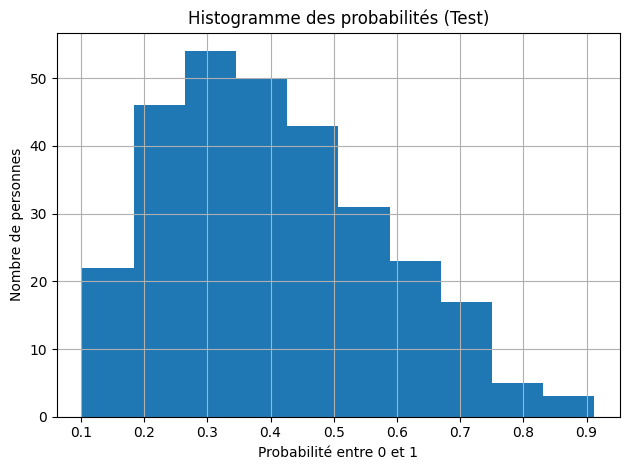

In [8]:
# Calcul de proba_test
proba_test = pipe.predict_proba(X_test)[:, 1]
# Histogramme des probabilités (Test)
plt.hist(proba_test)
plt.title("Histogramme des probabilités (Test)")
plt.xlabel("Probabilité entre 0 et 1")
plt.ylabel("Nombre de personnes")
plt.grid()
plt.tight_layout()
plt.show()

* Ce que l'on voit sur ce graphique c'est une concentration des probabilités entre 0.2 et 0.5, ce qui indique que le modèle donne des probabilités plutôt faible donc vers la classe négative, c'est à dire sur les salariés restants dans l'entreprise.
* On identifie un petit étalement à droite, donc que le modèle a quelques certitudes concernant des employés partis mais cela reste faible.
* L'histogramme représente bien notre jeu désequilibré avec des cas majoritairement dans la classe 0.
* Avec un seuil à 0.5 (celui de base), le modèle va donc classer plus de 0 que de 1.

### Ajout du calcul de l'average precision et création de la courbe PR

PR AUC (Average Precision) — TEST : 0.544


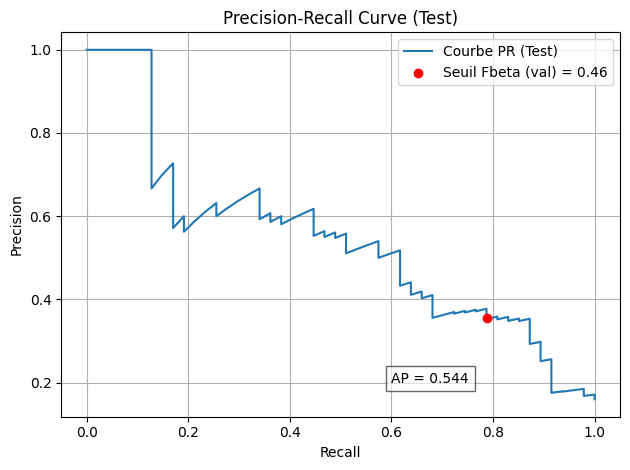

In [9]:
ap_test = average_precision_score(y_test, proba_test)   # PR AUC (Average Precision) — Test
print(f"PR AUC (Average Precision) — TEST : {ap_test:.3f}")
# Courbe PR (Test) pour visualiser + point au seuil optimal
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, proba_test)
# Point obtenu par application du seuil sur test
y_pred_custom = (proba_test >= best_thr).astype(int)
tp = ((y_test==1) & (y_pred_custom==1)).sum()
fp = ((y_test==0) & (y_pred_custom==1)).sum()
fn = ((y_test==1) & (y_pred_custom==0)).sum()
prec_pt = tp / (tp + fp)
rec_pt  = tp / (tp + fn)
plt.plot(recall_test, precision_test, label="Courbe PR (Test)")
plt.scatter(rec_pt, prec_pt, color="red", zorder=5, label=f"Seuil Fbeta (val) = {best_thr:.2f}")
plt.text(0.6, 0.2, f"AP = {ap_test:.3f}", fontsize=10, bbox=dict(facecolor='white', alpha=0.6))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Test)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

* Sur ce graphique nous retrouvons notre recall en abscisse et notre precision en ordonnée. Cette courbe représente le compromis entre le rappel et la précision. Chaque point de la courbe correspond à un seuil de décision différent.

* AP=0.544, le modèle fait mieux qu’un tirage aléatoire, mais il reste beaucoup de marge.
* Le point rouge correspond au seuil trouvé sur la validation (fbeta, donc favorisant le rappel) qui est donc de 0.46, il se trouve donc un peu plus bas que le seuil de standard de 0.50. Le modèle va chercher un score de probabilité plus bas pour récupérer des vrais positifs.

### Regardons à présent la différence de notre métrique de la balanced accuracy, entre le seuil de base et le seuil optimal calculé avec fbeta

In [10]:
y_pred_test = (proba_test >= 0.5).astype(int)      # seuil classique
y_pred_custom = (proba_test >= best_thr).astype(int)  # seuil optimal choisi

print("=== balanced accuracy score - TEST (0.5) ===")
print(round(balanced_accuracy_score(y_test, y_pred_test), 3))
print(f"=== balanced accuracy score - TEST (seuil F{beta:.1f} VALIDATION) ===")
print(round(balanced_accuracy_score(y_test, y_pred_custom), 3))

=== balanced accuracy score - TEST (0.5) ===
0.727
=== balanced accuracy score - TEST (seuil F2.0 VALIDATION) ===
0.758


* On obtient une meilleure moyenne des prévisions avec le seuil optimal, 0.758 vs 0.727

In [11]:
# Prédictions sur TRAIN et TEST avec le pipeline déjà fit
y_pred_train = pipe.predict(X_train) # afin de le faire apparaître dans ce notebook
y_pred_test  = pipe.predict(X_test) # afin de le faire apparaître dans ce notebook

# Prédictions custom avec le seuil optimal (best_thr)
print("=== Classification Report - TEST (0.5) ===")
print(classification_report(y_test, y_pred_test, digits=3))
print(f"=== Classification Report — TEST (seuil F{beta:.1f} VALIDATION) ===")
print(classification_report(y_test, y_pred_custom, digits=3))

=== Classification Report - TEST (0.5) ===
              precision    recall  f1-score   support

           0      0.927     0.773     0.843       247
           1      0.364     0.681     0.474        47

    accuracy                          0.759       294
   macro avg      0.645     0.727     0.659       294
weighted avg      0.837     0.759     0.784       294

=== Classification Report — TEST (seuil F2.0 VALIDATION) ===
              precision    recall  f1-score   support

           0      0.947     0.729     0.824       247
           1      0.356     0.787     0.490        47

    accuracy                          0.738       294
   macro avg      0.652     0.758     0.657       294
weighted avg      0.853     0.738     0.770       294



* On peut capter plus de TP avec une légère détérioration de la précision par rapport au seuil de base alors que nous avons un meilleur score en recall de +10%.

#### On peut analyser plus finement les résultats avec une comparaison des matrices de confusion

In [12]:
cm_test  = confusion_matrix(y_test, y_pred_test)
print("=== Matrice de confusion - TEST (0.5) ===")
print(cm_test)

cm_test_optimal  = confusion_matrix(y_test, y_pred_custom)
print(f"=== Matrice de confusion - TEST (seuil F{beta:.1f} VALIDATION) ===")
print(cm_test_optimal)

=== Matrice de confusion - TEST (0.5) ===
[[191  56]
 [ 15  32]]
=== Matrice de confusion - TEST (seuil F2.0 VALIDATION) ===
[[180  67]
 [ 10  37]]


* On capte 5 cas positifs en + mais on en capte 11 en + en FP

#### Ici le choix de mettre l'accent sur le recall nous donne un modèle capable de retrouver plus de départs au détriment d'une meilleure précision. L'objectif de la mission est de réaliser un modèle de classification capable de scorer la probabilité de départ d'un salarié afin d'en déterminer les causes potentielles. Afin de mieux comprendre les démissions, il faut donc réussir à retrouver le maximum de départs ce que nous aide à faire ce seuil.